In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from MiningMinima import *
from calc_hessian_at_min import *

PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python27.ubuntu 2019.33+release.1e60c63beb532fd475f0f704d68d462b8af2a977 2019-08-09T15:19:57] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r230 2019.33+release.1e60c63beb5 1e60c63beb532fd475f0f704d68d462b8af2a977 http://www.pyrosetta.org 2019-08-09T15:19:57
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2019.33+release.1e60c63beb5-py2.7-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=998275581 seed_offset=0 real_seed=998275581
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=998275581 RG_type=mt19937


# Developing subroutine to extract function derivative evaluations

In [169]:
# use mm object to get stuff 
seq1, seq2 = 'ggg', 'ccc'
mm_sim = MiningMinima(seq1,seq2, scorefxn='stepwise/rna/turner')

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

In [170]:
print mm_sim.hessian

[[  7.33556461e+01   4.70309812e+01   4.75534944e+01  -8.27902375e+01
   -2.11636612e+01  -8.34291409e+01   6.24427774e+01  -8.66704869e+01
    1.06212107e+02  -8.97258067e+01   6.55287645e+01   2.69120452e+00
   -1.08858924e+02   4.56751726e-01   3.47384517e+01  -6.04296869e+01
   -3.79939957e+01  -5.69247438e+01   5.94472599e+00  -7.12898943e+01
    6.69372055e+01  -1.40631023e+02   9.96001406e+00  -1.63392204e+02
   -2.18418994e+01  -8.48062470e+01]
 [  4.70309812e+01   5.14294403e+02   9.74493076e+01  -4.31398732e+02
    6.59074611e+01  -6.92692332e+02   1.02877354e+02  -4.58563248e+02
    8.63454551e+01  -4.20254343e+01   1.08360619e+02   1.09614132e+02
   -5.01543571e+02   1.78336447e+00   1.83192046e+02  -8.15149377e+02
    7.28301215e+01  -1.00617411e+03   3.27691913e+02  -8.73882939e+02
    2.42614891e+02  -2.29925065e+02   4.50717548e+02  -7.13999900e+02
    2.17942676e+02  -6.60407147e+02]
 [  4.75534944e+01   9.74493076e+01   4.44324092e+02  -1.73551730e+02
    5.32925070e+

In [171]:
# get pose and scorefxn 
pose = protocols.recces.pose_setup_turner(seq1=seq1,seq2=seq2)
scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('stepwise/rna/turner')

# set up movemap -- for now just get from the MM object -- and min map
movemap = MoveMap()
movemap.assign(mm_sim.movemap)  
min_map = core.optimization.MinimizerMap()
min_map.setup(pose,movemap)

# set up min options
min_options = core.optimization.MinimizerOptions(
    'lbfgs_armijo_nonmonotone',1e-15,True,False,False)
min_options.nblist_auto_update(True)
# get scorefunction ready for minimization
start_score = scorefxn(pose)
pose.energies().set_use_nblist(pose,min_map.domain_map(),True)
multifunc = core.optimization.AtomTreeMultifunc(pose,min_map,scorefxn)
scorefxn.setup_for_minimizing(pose,min_map) # this is the key command
scorefxn.setup_for_derivatives(pose)

min_dofs = Vector1([0.0]*min_map.nangles())
min_map.copy_dofs_from_pose(pose,min_dofs)
start_func_val = multifunc(min_dofs)
theta = Vector1(list(min_dofs))
dE_dtheta = Vector1(list(min_dofs))
multifunc.dfunc(theta,dE_dtheta)

# set up minimizer and run
minimizer = core.optimization.Minimizer(multifunc,min_options)
for _ in range(1): minimizer.run(min_dofs)
print dE_dtheta

core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 7.45058e-09 Deriv= -7.25459e-07 Finite Diff= 0.00499535
vector1_double[0.550895, 3.22237, 6.47997, -3.57721, 16.6513, -6.80738, 4.85879, -2.38824, -9.89882, 14.3929, 7.61632, 0.0652599, 7.25792, 0.0715411, 2.32111, -16.9005, 25.3648, -15.0324, 20.1156, -15.1348, -9.27694, 23.4974, 24.135, 20.8615, 15.4643, 6.53311]


In [172]:
multifunc.dfunc(min_dofs, dE_dtheta)

In [173]:
multifunc(min_dofs)

-84.73796381300126

In [174]:
multifunc(Vector1(list(mm_sim.min_dofs)))

-84.6472998617766

# Developing subroutine to calculate hessian from derivative evaluations

In [175]:
def hessian_at_min(min_dofs,multifunc,h=1e-3):
    min_dofs = np.array(min_dofs) # take advantage of numpy array indexing
    n_dofs = len(min_dofs)
    hessian = np.zeros((n_dofs,n_dofs))
    plus = Vector1([0.0]*n_dofs)
    minus = Vector1(list(plus))
    
    for ii in range(n_dofs):
        new_dofs = min_dofs[:]
        new_dofs[ii] += h*180./np.pi
        multifunc.dfunc(Vector1(list(new_dofs)),plus)
        new_dofs[ii] -= 2.*h*180/np.pi
        multifunc.dfunc(Vector1(list(new_dofs)),minus)
        row = (np.array(plus) - np.array(minus))/2./h
        hessian[ii] = row*(180./np.pi) # need to figure out conversion
    
    return 0.5*(hessian + hessian.T) # enforce symmetry

In [176]:
def hessian_naive(min_dofs, multifunc, h=1e-3):
    
    min_dofs = np.array(min_dofs)
    new_dofs = np.array(list(min_dofs))
    n_dofs = len(min_dofs)
    hessian_at_min = np.zeros((n_dofs, n_dofs))
    
    n_pts = 9
    ind = int(n_pts/2)
    
    tor_ranges = np.zeros((n_pts, n_dofs))
    energy = np.zeros((n_pts,n_pts))
    
    for ii in range(n_dofs):
        tor_ranges[:,ii] = min_dofs[ii] + np.linspace(-ind*h, ind*h, n_pts)*180./np.pi

    for pair in list(itertools.combinations(range(n_dofs), 2)):
        x_torsion = pair[0]
        y_torsion = pair[1]
        x = tor_ranges[:,x_torsion]
        y = tor_ranges[:,y_torsion]

        for ii, xx in enumerate(x):
            new_dofs[x_torsion] = xx

            for jj, yy in enumerate(y):
                new_dofs[y_torsion] = yy
                energy[ii,jj] = multifunc(Vector1(list(new_dofs)))
                new_dofs[y_torsion] = min_dofs[y_torsion]
                
            new_dofs[x_torsion] = min_dofs[x_torsion]
        
        hess = numpy_hessian(energy, h)
        d2E_dx2 =  hess[0,0,:,:]
        d2E_dy2 =  hess[1,1,:,:]
        d2E_dxdy = hess[0,1,:,:]
        
        if hessian_at_min[x_torsion, x_torsion] == 0:
            hessian_at_min[x_torsion, x_torsion] = d2E_dx2[ind,ind]
        if hessian_at_min[y_torsion, y_torsion] == 0:
            hessian_at_min[y_torsion, y_torsion] = d2E_dy2[ind,ind]
        
        hessian_at_min[x_torsion,y_torsion] = d2E_dxdy[ind,ind]
        hessian_at_min[y_torsion,x_torsion] = d2E_dxdy[ind,ind]

    return hessian_at_min

In [177]:
for _ in range(10):
    minimizer.run(min_dofs)
    print multifunc(min_dofs)

core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 9.53674e-09 Deriv= -7.25459e-07 Finite Diff= 0.0262007
-84.7379638131
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -7.25459e-07 Finite Diff= 0.002582
-84.7379638131
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -7.25459e-07 Finite Diff= 0.002582
-84.7379638131
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -7.25459e-07 Finite Diff= 0.002582
-84.7379638131
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -7.25459e-07 Finite Diff= 0.002582
-84.7379638131
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -7.25459e-07 Finite Diff= 0.002582
-84.7379638131
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -7.25459e-07 Finite Diff= 0.002582
-84.7379638131
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= 

In [178]:
min_map.copy_dofs_to_pose(pose, Vector1(list(min_dofs)))

In [179]:
hessian = hessian_at_min(min_dofs,multifunc)
hessian2 = hessian_naive(min_dofs, multifunc)

In [180]:
print hessian
print hessian2

[[  6.66400728e+01   4.00219708e+01   3.99123423e+01  -7.36865808e+01
   -2.50651922e+01  -7.55647763e+01   6.33708479e+01  -7.65502941e+01
    1.11453234e+02  -8.69848219e+01   6.49191321e+01   6.25610120e-01
   -1.03200834e+02   6.38961711e-01   3.00693164e+01  -4.32047831e+01
   -5.46920534e+01  -4.02644089e+01   1.27790911e+00  -5.51432723e+01
    7.84862247e+01  -1.48775397e+02   1.56686746e+00  -1.69535139e+02
   -3.28858180e+01  -8.48334144e+01]
 [  4.00219708e+01   4.23168632e+02   8.79589563e+01  -3.41074496e+02
    6.10043409e+01  -5.47916293e+02   9.18337137e+01  -3.60355508e+02
    7.61786493e+01  -4.84361620e+01   9.85933283e+01   9.34235252e+01
   -4.09150356e+02   4.07326696e+00   1.56945448e+02  -6.90540936e+02
    6.47897711e+01  -8.43143861e+02   2.82270857e+02  -7.41164748e+02
    2.06515315e+02  -2.10307272e+02   3.87814404e+02  -6.23635843e+02
    1.84773285e+02  -5.68526140e+02]
 [  3.99123423e+01   8.79589563e+01   4.11414781e+02  -1.68038343e+02
    5.00155680e+

In [181]:
from scipy.linalg import eigh

In [182]:
[eigenvalues, modes] = eigh(hessian)
[eig2, mode2] = eigh(0.5*(hessian2+hessian2.T))

In [205]:
print np.linalg.norm(hessian-hessian2)

0.0558315940333


In [184]:
print eigenvalues, eig2

[  8.04610035e+00   1.11461055e+01   1.35736495e+01   1.42488438e+01
   1.56329672e+01   2.12457478e+01   2.42292693e+01   2.47027479e+01
   2.75668521e+01   4.38659596e+01   4.71460219e+01   7.17332652e+01
   7.67952707e+01   1.34171389e+02   1.94955762e+02   2.50453252e+02
   2.69797573e+02   4.72956440e+02   5.61716468e+02   1.15310191e+03
   1.54376187e+03   1.74271391e+03   2.86956387e+03   6.00885097e+03
   1.69749714e+04   1.88399142e+04] [  1.11344786e+01   1.37229597e+01   1.45334216e+01   1.54100784e+01
   1.72083721e+01   2.01229555e+01   2.19607043e+01   2.54782135e+01
   3.12305645e+01   4.83433251e+01   5.24302808e+01   7.15875178e+01
   7.69993146e+01   1.35555760e+02   1.69492697e+02   2.53436726e+02
   2.63746516e+02   4.63961944e+02   5.37721288e+02   1.13883061e+03
   1.53581047e+03   1.70435737e+03   2.85352636e+03   5.95060215e+03
   1.56366072e+04   1.88230245e+04]


In [185]:
for do in min_map.dof_nodes():
    print min_map.torsion_scale_factor(do)

57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131


In [202]:
pseudo_det = 1.
for eigen in eig2:
    if eigen > 0:
        pseudo_det *= eigen
    

In [203]:
print multifunc(min_dofs) + 0.5*np.log(pseudo_det) - 0.5*min_map.nangles()*np.log(2*np.pi)

-41.6045809788


# Developing subroutine to mode scan using AtomTreeMultifunc

In [188]:
pmm = PyMOLMover()
pmm.keep_history(True)

In [189]:
from scipy.special import erf

In [190]:
def mode_scan(min_dofs, multifunc, mode, limit=np.pi/3, dx=0.005):
    # convert to np array for useful indexing
    min_dofs = np.array(min_dofs)
    delta_array = np.linspace(-limit, limit, int(2*limit/dx)+1)
    
    # intialize result
    result = np.zeros_like(delta_array)
    
    # evaluate using multifunc 
    for ii, delta in enumerate(delta_array):
        new_dofs = np.array(min_dofs) + delta*mode*180/np.pi
        result[ii] = multifunc(Vector1(list(new_dofs)))
    
    return result    
    
    

In [191]:
def compute_total_partition(min_dofs, multifunc, modes, limit=np.pi/3, dx=0.005):
    # initialize output
    total_log_partition = 0 
    total_log_harmonic = 0
    scans = tuple()
    xx = np.linspace(-limit, limit, int(2*limit/dx)+1)
    
    for ii, mode in enumerate(modes.T): # columns of array are eigenvectors
        if eig2[ii] < 0: continue
        result = mode_scan(min_dofs, multifunc, mode, limit=limit, dx=dx)
        result -= multifunc(min_dofs)
        scans = scans + (result,)
        total_log_partition += np.log(np.trapz(np.exp(-result),dx=dx))
        #total_log_harmonic += np.log(np.trapz(np.exp(-eigenvalues[ii]*xx**2),dx=dx))
        total_log_harmonic += np.log( np.sqrt(2*np.pi/eigenvalues[ii])*(erf(2*limit/np.sqrt(2/eigenvalues[ii]))))
    scans = np.row_stack(scans)
    return total_log_partition, total_log_harmonic, scans

In [192]:
total_log_partition, total_log_harmonic, mode_scans = compute_total_partition(min_dofs, multifunc, mode2)

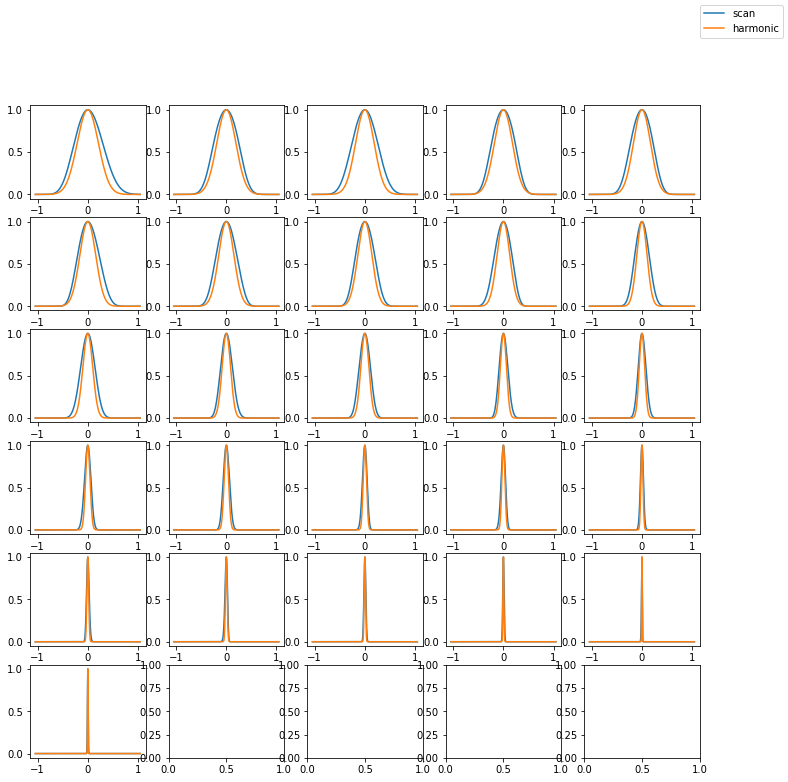

In [193]:
xx = np.linspace(-np.pi/3,np.pi/3,int(2*np.pi/3/0.005)+1)
fig, ax = plt.subplots(ncols=5,nrows=6,figsize=(12,12))
for ii, scan in enumerate(mode_scans):
    if eigenvalues[ii] < 0: continue
    curr_ax = ax.flatten()[ii]
    curr_ax.plot(xx,np.exp(-scan))
    curr_ax.plot(xx,np.exp(-eig2[ii]*xx**2))
fig.legend(('scan', 'harmonic'))

In [194]:
from numpy.linalg import det
from numpy import heaviside
from scipy.special import logsumexp
from scipy.special import gamma

In [195]:
n = min_map.nangles()
min_E = multifunc(min_dofs)
dos = lambda E: (2.0*np.pi)**(n/2.)*(E-min_E)**(n/2. - 1)/gamma(n/2.)/np.sqrt(pseudo_det)*heaviside(E-min_E,0.5)

In [196]:
E = np.linspace(-100, 800, 90001)
F = np.linspace(-100,800,9001)
print -logsumexp(-(E), b=dos(E)*0.01) 
print -logsumexp(-F,b=dos(F)*0.1)


-41.9250889161
-41.9250889161


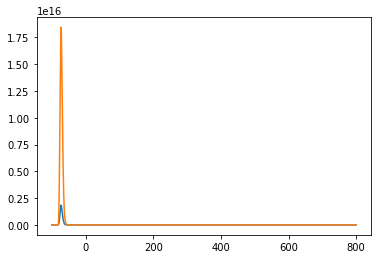

In [197]:
plt.plot(E, dos(E)*np.exp(-E)*0.01)
plt.plot(F, dos(F)*np.exp(-F)*0.1)


In [198]:
print n

26


In [201]:
multifunc(min_dofs) - total_log_partition

-40.370791135765145

In [200]:
total_log_partition, total_log_harmonic

(-44.367172677309412, -42.812874899782784)

In [ ]:
sims = ['aaa_uuu', 'aa_uu', 'cc_gg', 'ccc_ggg', 'cc_gg', 'gaa_uuc', 'gac_guc', 'gag_cuc', 'gau_auc', 'ga_uc', 'gcc_ggc', 'gcg_cgc', 'gga_ucc', 'gg_cc', 'ggc_gcc', 'ggg_ccc', 'ggu_acc', 'gu_ac', 'guc_gac', 'guu_aac']

harmonic_E = []
RECCES_E = []
DOS_E = []

E = np.linspace(-100,800,9001)

for sim in sims:
    
    seqs = sim.split('_')
    seq1 = seqs[0]
    seq2 = seqs[1]
    
    fuck = MiningMinima(seq1, seq2)
    
    hist = SingleHistSimulation('./../../../recces_rosetta/results/'+sim+'/ST/')
    
    harmonic_E.append(fuck.harmonic_free_energy)
    RECCES_E.append(hist.value)
    DOS_E.append(-scipy.special.logsumexp(-E, b=fuck.dos(E)))

In [ ]:
print RECCES_E
print harmonic_E
print DOS_E
plt.scatter(RECCES_E, DOS_E)
plt.plot([-45,-15],[-45,-15])

In [ ]:
from recces.util import *
from recces.data import *

In [ ]:
sim = SingleHistSimulation('./../../../recces_rosetta/results/'+seq1+'_'+seq2+'/ST/')

In [ ]:
print sim.value
-np.log(np.trapz(sim._dos, dx=0.1))
'guu_acc'.split('_')

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

E = np.linspace(-100,100,2001)

plt.plot(E, fuck.dos(E)*np.exp(-E))
plt.plot(sim._dos_scores[:2000], sim._dos[:2000]*np.exp(-sim._dos_scores[:2000]))
plt.xlabel('energy (REU)')
plt.ylabel('$g(E)e^{-E/kT}$')
plt.legend(('MM', 'RECCES'))
print -scipy.special.logsumexp(-E, b=fuck.dos(E)), sim.value, fuck.harmonic_free_energy

In [ ]:
print fuck.anharmonic_free_energy
print fuck.harmonic_free_energy

In [ ]:

print fuck.modes[:,0]
pmm.apply(fuck.min_pose)

In [ ]:
n_struct = 200

ensemble = fuck.harmonic_ensemble(n_struct = n_struct)
#print ensemble[2,:]-min_dofs
#print np.sqrt(H)/np.sqrt((2*np.pi)**fuck.n_dofs)*np.exp(-np.dot(fuck.eigenvalues, ((min_dofs-ensemble[0,:])*np.pi/180)**2)/2)

In [ ]:
pose = Pose()
pose.assign(fuck.min_pose)

hist_min = -100
hist_max = 100
delE = 0.1

hist_scores = np.linspace(hist_min, hist_max, int((hist_max-hist_min)/delE)+1)

hist = np.zeros_like(hist_scores)

for i in range(n_struct):
    
    dofs = ensemble[i,:]
    
    for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key], dofs[key])
        
    energy = fuck.scorefxn(pose)
    
    if energy < hist_max+delE:
             
        hist_idx = math.floor((energy-hist_min)/delE)
        hist_idx = int(hist_idx)
        hist[hist_idx] += 1


In [ ]:
shit = hist*np.exp(hist_scores)/np.sum(hist)
shit = shit/np.sum(shit)
print -scipy.special.logsumexp(-hist_scores, b = shit)
plt.plot(hist_scores, shit*np.exp(-hist_scores)/torsion_volume(seq1, seq2))
plt.plot(sim._dos_scores[:2000], sim._dos[:2000]*np.exp(-sim._dos_scores[:2000]))

In [ ]:
pose = Pose()
pose_new = Pose()
pose.assign(fuck.min_pose)
for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key],ensemble[0,:][key])

pose_new.assign(pose)

E_0 = fuck.scorefxn(fuck.min_pose)
energy = E_0

min_dofs = [fuck.min_pose.torsion(fuck.dof_dict[key]) for key in fuck.dof_dict]
curr_dofs = min_dofs
print min_dofs

Z = 0
H = np.product(fuck.eigenvalues)

for j in range(1,n_struct):
    
    trial_move = ensemble[j, :]
     
    for key in fuck.dof_dict: pose_new.set_torsion(fuck.dof_dict[key], trial_move[key]) 

    energy_new = fuck.scorefxn(pose_new)
    
    if np.exp(-(energy_new-energy)) > np.random.random():
        
        energy = energy_new
        pose.assign(pose_new)
        curr_dofs = trial_move
        
    

        #p = np.sqrt(H/(2*np.pi)**fuck.n_dofs)*np.exp(-np.dot(fuck.eigenvalues, ((trial_move-min_dofs)*(np.pi/180)**2)**2)/2)
    if energy < hist_max+delE:
             
        hist_idx = math.floor((energy-hist_min)/delE)
        hist_idx = int(hist_idx)
        hist[hist_idx] += 1

    

In [ ]:
#plt.plot(hist_scores, hist)
shit = hist/np.sum(hist)
shit = shit*np.exp(hist_scores)
shit = shit/np.sum(shit)
#plt.plot(hist_scores, shit)
plt.plot(hist_scores, hist/np.sum(hist))
print -np.log(np.exp(-E_0)*(0.25)**fuck.n_dofs/0.35)


In [ ]:
print ensemble
pmm = PyMOLMover()
pmm.keep_history(True)
print ensemble[1,:]

In [ ]:
pose = Pose()
pose.assign(fuck.min_pose)

for i in range(200):
    
    dofs = ensemble[i,:]
    for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key], dofs[key]) 
    pmm.apply(pose)
    

In [ ]:
print np.cov(ensemble)

In [ ]:
w,v = np.linalg.eigh(np.cov(ensemble.T))
print fuck.eigenvalues

In [ ]:
print 1/w*180*180/np.pi/np.pi

In [ ]:

print fuck.min_energy - 0.5*fuck.n_dofs*np.log(2*np.pi) + 0.5*np.log(np.prod(1/w))

In [ ]:
print fuck.anharmonic_free_energy

In [ ]:
print fuck.min_pose

In [ ]:
mu = np.zeros(fuck.n_dofs)

In [ ]:
print mu

In [ ]:
mu = [fuck.min_pose.torsion(fuck.dof_dict[key]) for key in fuck.dof_dict]

In [ ]:
print mu
bitch = np.linalg.inv(fuck.hessian)

In [ ]:
shit = np.random.multivariate_normal(mu, bitch, size=(2000))

In [ ]:
print shit[0,:]

In [ ]:
random_struct = np.zeros((fuck.n_dofs, 2000))

for j in range(2000):
    
    random_struct[:,j] = np.random.multivariate_normal(mu, bitch)

In [ ]:
print random_struct

In [ ]:
print np.cov(random_struct)

In [ ]:
w,v = np.linalg.eigh(np.cov(random_struct))

In [ ]:
print 1/w


In [ ]:
cu_ag = MiningMinima('cuc', 'gag')

In [ ]:
cu_ag.harmonic_free_energy

In [ ]:
ensemble = cu_ag.harmonic_ensemble()

In [ ]:
cu_ag.eigenvalues

In [ ]:
np.diag(1/cu_ag.eigenvalues)

In [ ]:
np.matmul( np.matmul( cu_ag.modes, np.diag(1/cu_ag.eigenvalues)), cu_ag.modes.T)

In [ ]:
np.linalg.inv(cu_ag.hessian)